# LPSpline Demo

This notebook demonstrates how to use the `lpspline` package to build and optimize linear spline models using the additive API.

In [1]:
import numpy as np
import polars as pl
try:
    import matplotlib.pyplot as plt
except ImportError:
    import os
    os.system('pip install matplotlib')
    import matplotlib.pyplot as plt
from lpspline import l, pwl, bs, cs, f
from lpspline.viz import plot_components

# Set seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We create a dataset with various non-linear relationships.

In [ ]:
n = 1000
x_linear = np.linspace(0, 10, n)
x_pwl = np.linspace(0, 10, n)
x_bs = np.linspace(0, 10, n)
x_cyc = np.linspace(0, 2*np.pi, n)
x_factor = np.random.randint(0, 3, n)

# True functions
y_linear = 0.5 * x_linear
y_pwl = np.where(x_pwl < 5, 0, x_pwl - 5) # Hinge at 5
y_bs = np.sin(x_bs) # Sine wave
y_cyc = np.cos(x_cyc) # Cosine wave
y_factor = np.array([0, 2, -1])[x_factor] # Categorical effects

# Combined target with noise
y = y_linear + y_pwl + y_bs + y_cyc + y_factor + np.random.normal(0, 0.2, n)

df = pl.DataFrame({
    "xl": x_linear,
    "xpwl": x_pwl,
    "xbs": x_bs,
    "xcyc": x_cyc,
    "xfactor": x_factor,
    "y": y
})

print(df.head())

shape: (5, 6)
┌────────────┬─────────┬─────────┬──────────┬────────────┬──────────┐
│ linear_col ┆ pwl_col ┆ bs_col  ┆ cyc_col  ┆ factor_col ┆ target   │
│ ---        ┆ ---     ┆ ---     ┆ ---      ┆ ---        ┆ ---      │
│ f64        ┆ f64     ┆ f64     ┆ f64      ┆ i64        ┆ f64      │
╞════════════╪═════════╪═════════╪══════════╪════════════╪══════════╡
│ 0.0        ┆ 0.0     ┆ 0.0     ┆ 0.0      ┆ 2          ┆ 0.009704 │
│ 0.01001    ┆ 0.01001 ┆ 0.01001 ┆ 0.006289 ┆ 0          ┆ 0.848805 │
│ 0.02002    ┆ 0.02002 ┆ 0.02002 ┆ 0.012579 ┆ 2          ┆ 0.084041 │
│ 0.03003    ┆ 0.03003 ┆ 0.03003 ┆ 0.018868 ┆ 2          ┆ 0.034815 │
│ 0.04004    ┆ 0.04004 ┆ 0.04004 ┆ 0.025158 ┆ 0          ┆ 1.011943 │
└────────────┴─────────┴─────────┴──────────┴────────────┴──────────┘


## 2. Define API and Model

We define the components and add them together to create the model.

In [ ]:
# Create model using additive syntax
model = (
    l(term='xl', bias=True)
    + pwl(term='xpwl', knots=[5.])
    + bs(term="xbs", knots=np.linspace(0, 10, 5), degree=3)
    + cs(term="xcyc", period=2*np.pi, order=2)
    + f(term="xfactor", n_classes=3)
)

## 3. Fit the Model

We use the `fit` method on the combined model.

In [4]:
model.fit(df, df["target"])

print("Model fitted successfully.")


✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------
Spline Type          | Term            | Params    
--------------------------------------------------
🟢 Linear            | linear_col      | 2         
🟢 PiecewiseLinear   | pwl_col         | 3         
🟢 BSpline           | bs_col          | 1         
🟢 CyclicSpline      | cyc_col         | 5         
🟢 Factor            | factor_col      | 3         
--------------------------------------------------
📊 Total Parameters                    | 14        

Model fitted successfully.


## 4. Predict and Evaluate

We generate predictions and visualize the fit.

Mean Squared Error: 0.0422


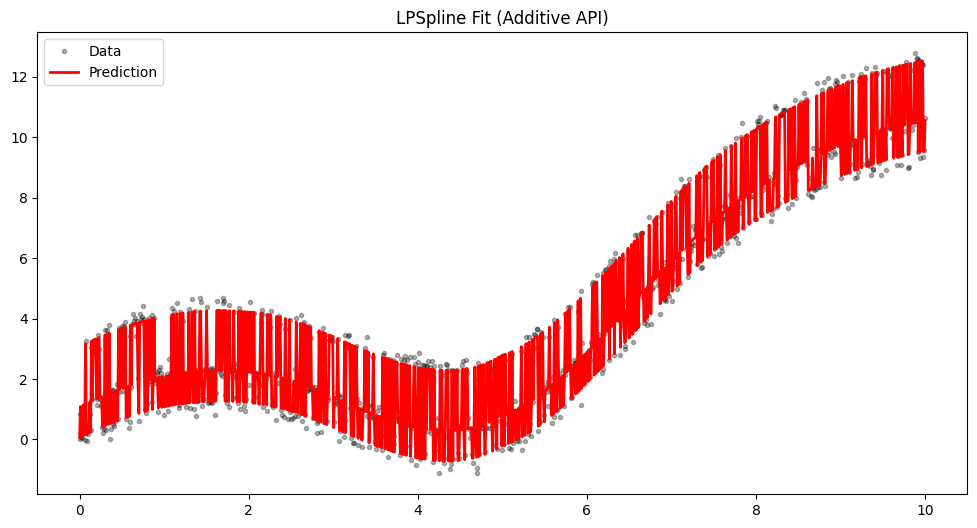

In [5]:
predictions = model.predict(df)
mse = np.mean((predictions - df["target"].to_numpy())**2)
print(f"Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["linear_col"], df["target"], 'k.', alpha=0.3, label='Data')
plt.plot(df["linear_col"], predictions, 'r-', linewidth=2, label='Prediction')
plt.legend()
plt.title("LPSpline Fit (Additive API)")
plt.show()

## 5. Visualize Spline Components

We can also visualize the individual effect of each spline component.

(<Figure size 1500x800 with 5 Axes>,
 array([<Axes: xlabel='linear_col'>, <Axes: xlabel='pwl_col'>,
        <Axes: xlabel='bs_col'>, <Axes: xlabel='cyc_col'>,
        <Axes: xlabel='factor_col'>, <Axes: >], dtype=object))

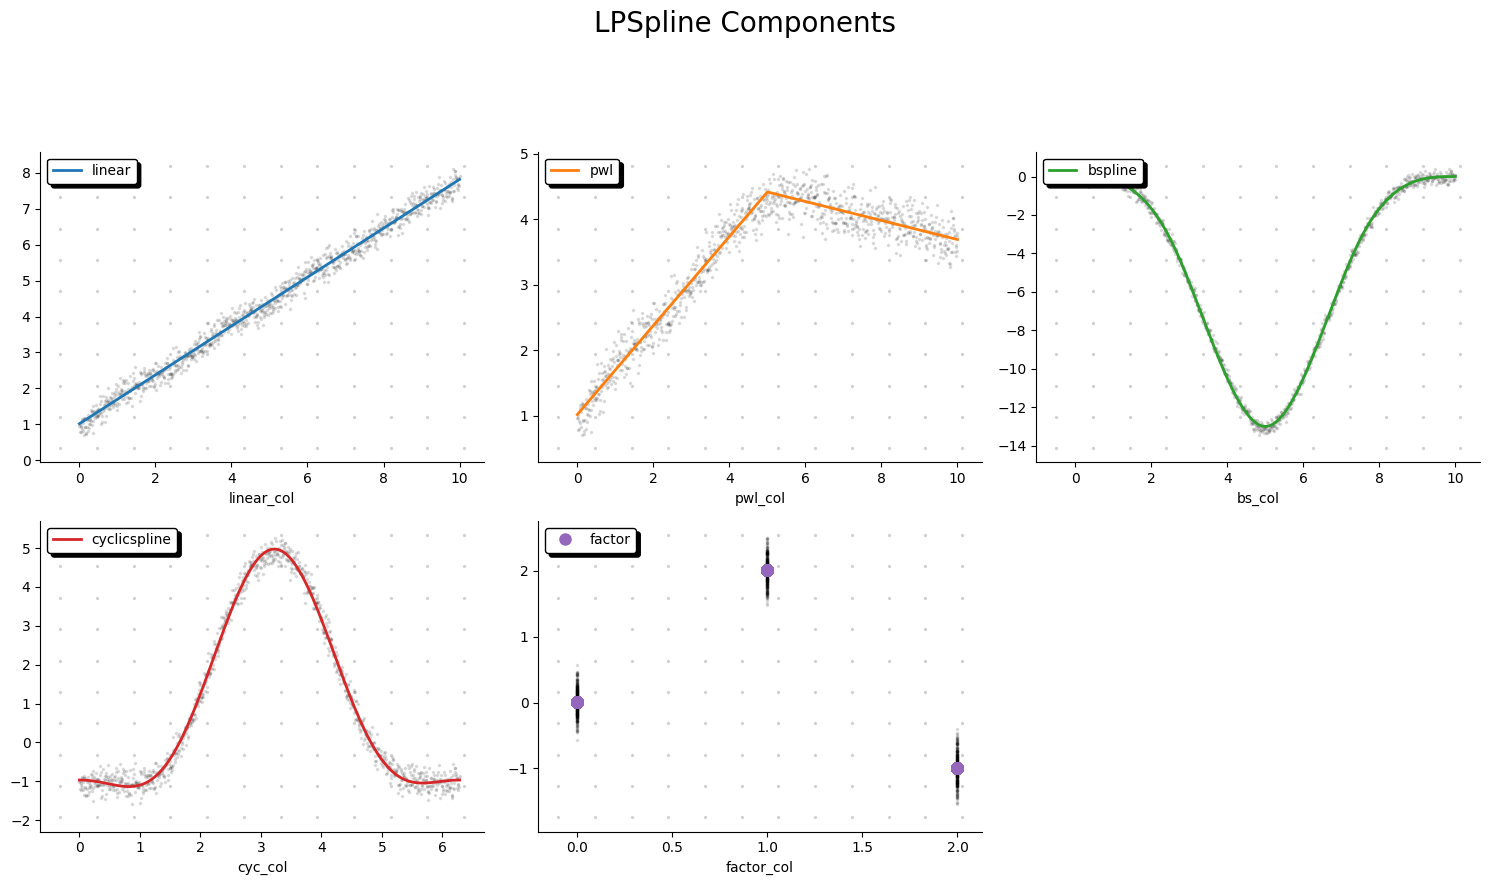

In [ ]:
plot_components(model=model, X=df, ncols=3, y=df['target'])